## 라이브러리 / 기본셋업


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import os

버전 확인

- `python` >= 3.10.12
- `numpy` >= 1.26.0
- `pandas` >= 2.1.1
- `matplotlib` >= 3.8.1
- `seaborn` >= 0.13.0
- `missingno` >= 0.5.2

In [2]:
import sys, matplotlib

print("="*5 ,"나의 라이브러리 버전 확인", "="*5)
print(f"{'python version':15s} <> {sys.version}")
print(f"{'numpy version':15s} <> {np.__version__}")
print(f"{'pandas version':15s} <> {pd.__version__}")
print(f"{'matplotlib version':15s} <> {matplotlib.__version__}")
print(f"{'seaborn version':15s} <> {sns.__version__}")
print(f"{'missingno version':15s} <> {msno.__version__}")

===== 나의 라이브러리 버전 확인 =====
python version  <> 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
numpy version   <> 1.26.3
pandas version  <> 2.1.4
matplotlib version <> 3.8.2
seaborn version <> 0.13.1
missingno version <> 0.5.2


# 데이터셋

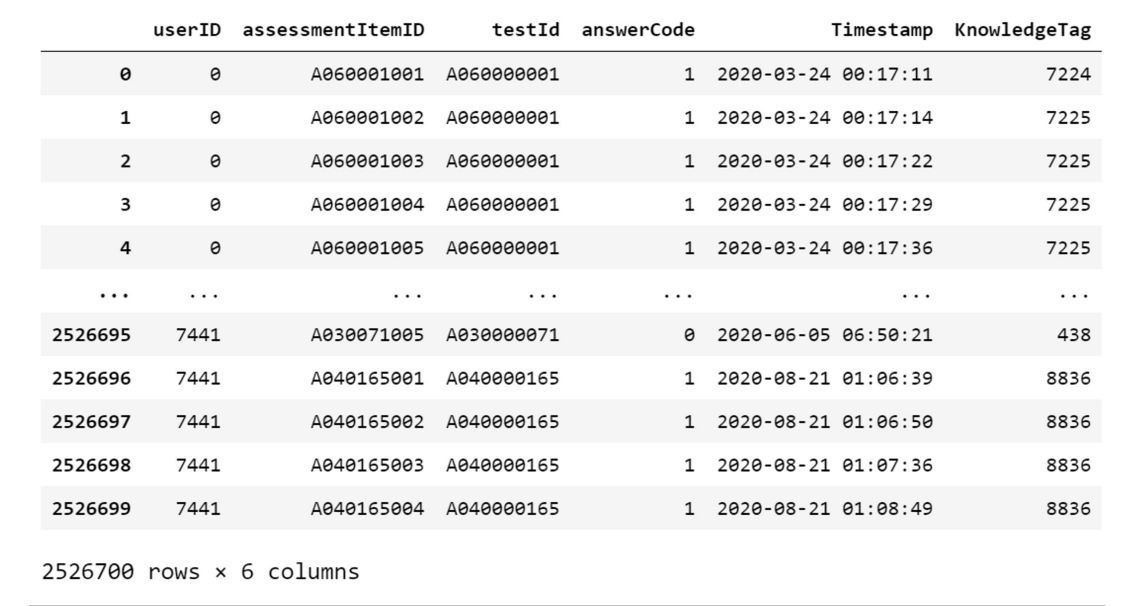

**userID**

총 7,442명의 고유한 사용자 존재

**assessmentItemID**

총 9,454개의 고유한 문항

**testId**

총 1,537개의 고유한 시험지

**answerCode**

사용자가 문항을 맞았는지 여부를 담은 이진 데이터

**Timestamp**

사용자가 Interaction을 시작한 시간 정보

**KnowledgeTag**

총 912개의 고유 태그


In [3]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}

# Data load
data_path = "/data/ephemeral/home/level2-dkt-recsys-06/data/"

train = pd.read_csv(data_path + 'train_data.csv', dtype=dtype, parse_dates=['Timestamp'])
test = pd.read_csv(data_path + 'test_data.csv', dtype=dtype, parse_dates=['Timestamp'])

CPU times: user 2.95 s, sys: 353 ms, total: 3.3 s
Wall time: 3.31 s


In [4]:
train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225


In [5]:
test.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623


In [6]:
# merge data
merge_train = pd.concat([train, test], axis=0)
merge_train = merge_train.sort_values(by=["userID", "Timestamp", "assessmentItemID"]).reset_index(drop=True)

# 정답률에 평균을 사용할 예정이기에 -1인 answer code는 0.5로 변환, 추후에 다시 복구할 예정
fill_value=0.5
merge_train['answerCode'] = merge_train['answerCode'].apply(lambda x: fill_value if x == -1 else x)

# 자료형 변환
데이터 크기가 커지는 것을 방지하기 위하여 중복된 정보를 제거하였다.

## 1.'assessmentItemID' 변환
A 제거하고 시험번호 및 문제번호만 남김.

문제 번호 열 새로 생성

In [7]:
def process_assessmentItemID(df):
    df['assessmentItemID'] = df['assessmentItemID'].str[1:]
    df['Itemseq'] = df['assessmentItemID'].str[-3:].astype(int)
    return df

merge_train = process_assessmentItemID(merge_train)

## 2.'testId' 변환
열에서 2~ 4과 8~ 10 남김(시험번호)

In [8]:
def process_testId(df):
    df['testId'] = df['testId'].apply(lambda x: x[1:4] + x[7:])
    return df

merge_train = process_testId(merge_train)

## 결과확인

In [9]:
merge_train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Itemseq
0,0,060001001,060001,1.0,2020-03-24 00:17:11,7224,1
1,0,060001002,060001,1.0,2020-03-24 00:17:14,7225,2
2,0,060001003,060001,1.0,2020-03-24 00:17:22,7225,3
3,0,060001004,060001,1.0,2020-03-24 00:17:29,7225,4
4,0,060001005,060001,1.0,2020-03-24 00:17:36,7225,5


# Feature Engineering

**0) 기본**

userID: 총 7,442명의 고유한 사용자 존재

assessmentItemID: 총 9,454개의 고유한 문항

testId: 총 1,537개의 고유한 시험지

answerCode: 사용자가 문항을 맞았는지 여부를 담은 이진 데이터

Timestamp: 사용자가 Interaction을 시작한 시간 정보

KnowledgeTag: 총 912개의 고유 태그


**1) Timestamp 관련**

SolvingTime: 유저가 해당 문제푸는데 걸린 시간

CumulativeTime: 유저가 해당 시험에서 그 문제까지의 누적 시간

Month: 달

DayOfWeek: 요일

TimeOfDay: 시간

WeekOfYear: 해당연도의 몇번째 주


**2) User 관련**

UserAvgSolvingTime: 유저의 평균 문제풀이 소요시간 (중앙값)

RelativeUserAvgSolvingTime: 유저의 상대적 풀이시간(편차), 해당문제 유저 소요시간과 유저 평균 소요시간과의 차이, SolvingTime - UserAvgSolvingTime

CumulativeItemCount: 그동안 몇개의 문제를 풀었는지

Item_last7days: 일주일간 푼 문제 수

Item_last30days: 한달 간 푼 문제 수

CumulativeUserItemAcc: 처음까지 푼 유저의 누적 문제 정답률

PastItemCount: 해당 문제를 과거에 푼 횟수

UserItemElapsed: 과거 해당 문제를 푼지 얼마나 시간이 경과하였는지

UserRecentItemSolvingTime: 최근 같은 문제에는 얼마나 시간이 걸렸는지

**3) Item 관련**

Itemseq: test내 문제 번호

ItemAcc: 문제 정답률

AverageItemSolvingTime_Correct: 해당문제 맞은 사람들 평균 소요시간 (중앙값)

AverageItemSolvingTime_Incorrect: 해당문제 틀린 사람들 평균 소요시간 (중앙값)

AverageItemSolvingTime: 해당문제 평균 소요시간 (중앙값)

Difference_SolvingTime_AvgItemSolvingTime: 해당문제 유저 소요시간과 Item 평균 소요시간과의 차이

**4) Tag 관련**

UserTagAvgSolvingTime: 유저의 태그별 풀이시간 평균 (중앙값)

TagAcc: 태그 정답률

CumulativeUserTagAverageAcc: 유저 Tag 기준 과거 정답률

CumulativeUserTagExponentialAverage: 유저 Tag 기준 과거 정답률 지수평균

UserTagCount: 유저당 태그당 푼 누적 문제 수

UserTagElapsed: 과거 같은 태그 문제를 푼지 얼마나 시간이 경과하였는지

UserRecentTagSolvingTime: 최근 같은 문제에는 얼마나 시간이 걸렸는지

UserRecentTagAnswer: 해당 태그의 가장 최근 정답여부

**5) Test 관련**

UserRecentItemAnswer: 같은 테스트 바로 이전 문제 정답 여부

TestAcc: 테스트 전체 정답률

**결측치**

SolvingTime: 해당 시험의 평균으로 대체

CumulativeTime: 이하 동문

**범주화**

categorize_solvingTime: 10개로 범주화

categorize_ItemAcc: 7개로 범주화(난이도)

categorize_TagAcc: 7개로 범주화(난이도)

categorize_TestAcc: 5개로 범주화(정답률)

categorize_CumulativeUserItemAcc: 5개로 범주화(정답률)

categorize_CumulativeUserTagAverageAcc: 5개로 범주화(정답률)

categorize_CumulativeUserTagExponentialAverage: 5개로 범주화(정답률)

CategorizedDegree: 풀이시간 정도 범주화
 A:correct를 넘어가 버림, B:correct근처 C:correct 평균사이 D: 평균 근처
 E:평균 Incorrect 사이, F:Incorrect근처 G:Incorrect를 넘어가 버림

# 1) Timestamp 관련
SolvingTime: 유저가 해당 문제푸는데 걸린 시간

CumulativeTime: 유저가 해당 시험에서 그 문제까지의 누적 시간

Month: 달

DayOfWeek: 요일

TimeOfDay: 시간

WeekOfYear: 해당연도의 몇번째 주


**결측치**

SolvingTime: 해당 시험의 평균으로 대체

CumulativeTime: 이하 동문

## 1.SolvingTime, CumulativeTime 생성
 1) 해당 문제를 푸는데 걸린 시간(초)

  -만약 10분 이상 푼 문제가 있다면 풀이시간이 10분인 것으로 조정한다.

 2) 해당 시험지 내에서 해당 문제 전까지 누적 풀이 시간(초)

In [10]:
def add_solving_time(df):
    df['NextTimestamp'] = pd.to_datetime(df.groupby(['userID', 'testId'])['Timestamp'].shift(-1))
    df['SolvingTime'] = (df['NextTimestamp'] - df['Timestamp']).dt.total_seconds()
    df.loc[df['SolvingTime'] >= 600, 'SolvingTime'] = 600
    df['CumulativeTime'] = df.groupby(['userID', 'testId'])['SolvingTime'].cumsum()
    df = df.drop(columns=['NextTimestamp'])
    return df

merge_train = add_solving_time(merge_train)
## Issue : 시험지 내 마지막 문제에 Solvingtime 결측

## 시각화를 통한 EDA 결과 확인

In [11]:
# SolvingTime에 따른 정답률 시각화
def visualize_answer_rate_by_solving_time(df):
    df_no_nan = df['SolvingTime'].dropna()
    quantiles = df_no_nan.quantile(np.arange(0, 1.1, 0.1))  # 상위 0~10% 풀이시간부터 90~100%까지 10분위로 나눔
    time_bin = pd.cut(df_no_nan, bins=quantiles, include_lowest=True)
    bin_answer_rate = df.loc[time_bin.index].groupby(time_bin)['answerCode'].mean()
    bin_labels = ["{:.0f}s ~ {:.0f}s".format(bin.left, bin.right) for bin in bin_answer_rate.index.categories[:-1]]
    bin_labels.append("{:.0f}s~".format(bin_answer_rate.index.categories[-1].left))

    plt.figure(figsize=(12, 6))
    plt.bar(x=np.arange(len(bin_answer_rate)), height=bin_answer_rate.values, tick_label=bin_labels)
    plt.xlabel('Solving Time')
    plt.ylabel('Answer Rate')
    plt.title('Solving Time vs Answer Rate')
    plt.xticks(rotation=45)
    plt.show()

# visualize_answer_rate_by_solving_time(merge_train)

결과 해석 : 0~7초 (풀이시간 하위 20%)의 풀이 시간을 가질 경우 오답 비율이 굉장히 높았다. 찍었다는 의미

## SolvingTime, CumulativeTime 결측치

### 1.SolvingTime이 결측치 채우기
SolvingTime이 결측일 때 해당 유저의 해당 시험의 평균 걸린 시간으로 채워준다

In [12]:
def count_missing_solving_time(df):
    missing_solving_time = df['SolvingTime'].isnull().sum()
    print(f"EDA전 SolvingTime 열의 결측치 개수: {missing_solving_time}")

count_missing_solving_time(merge_train)

EDA전 SolvingTime 열의 결측치 개수: 407189


In [13]:
def fill_missing_solving_time(df):
    grouped = df.groupby(['userID', 'testId'])['SolvingTime'].transform('median')
    df['SolvingTime'] = df['SolvingTime'].fillna(grouped)

    return df

merge_train = fill_missing_solving_time(merge_train)

In [14]:
def count_missing_solving_time(df):
    missing_solving_time = df['SolvingTime'].isnull().sum()
    print(f"EDA후 SolvingTime 열의 결측치 개수: {missing_solving_time}")

count_missing_solving_time(merge_train)

EDA후 SolvingTime 열의 결측치 개수: 0


### 2.CumulativeTime 결측치
SolvingTime이 결측 채운것을 바탕으로 CumulativeTime 결측치를 채운다.

In [15]:
def count_missing_cumulative_time(df):
    missing_cumulative_time = df['CumulativeTime'].isnull().sum()
    print(f"EDA전 CumulativeTime 열의 결측치 개수: {missing_cumulative_time}")

count_missing_cumulative_time(merge_train)

EDA전 CumulativeTime 열의 결측치 개수: 407189


In [16]:
def fill_missing_CumulativeTime(df):
    # 결측값이 있는 행을 선택
    missing_CumulativeTime_rows = df[df['CumulativeTime'].isnull()]

    # 결측값이 있는 행에 대해 루프 수행
    for index, row in missing_CumulativeTime_rows.iterrows():
        # 이전 행의 CumulativeTime가져오기
        prev_cumulative_time = df.at[index - 1, 'CumulativeTime']

        # 현재 행의 solving_time 가져오기
        solving_time = df.at[index, 'SolvingTime']

        # CumulativeTime 갱신
        CumulativeTime = prev_cumulative_time +solving_time

        # SolvingTime 값을 해당 행에 채워 넣기
        df.at[index, 'CumulativeTime'] = CumulativeTime
    return df

merge_train = fill_missing_CumulativeTime(merge_train)

In [17]:
def count_missing_cumulative_time(df):
    missing_cumulative_time = df['CumulativeTime'].isnull().sum()
    print(f"EDA후 CumulativeTime 열의 결측치 개수: {missing_cumulative_time}")

count_missing_cumulative_time(merge_train)

EDA후 CumulativeTime 열의 결측치 개수: 0


## 2.Month, DayOfWeek, TimeOfDay, WeekOfYear
문제를 푼 달, 요일, 시간. 해당연도의 몇번째 주

In [18]:
def process_timestamp(df):
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Month'] = df['Timestamp'].dt.month
    df['DayOfWeek'] = df['Timestamp'].dt.dayofweek
    day_dict = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'}
    df['DayOfWeek'] = df['DayOfWeek'].map(day_dict)

    df['TimeOfDay'] = df['Timestamp'].dt.hour

    #'WeekOfYear'열 추가
    df['WeekOfYear'] = df['Timestamp'].dt.isocalendar().week

    return df

merge_train = process_timestamp(merge_train)

## 시각화를 통한 EDA 결과 확인

In [19]:
def visualize_answer_rate_by_category(df):
    # 각 달에 따른 정답률 계산
    month_answer_rate = df.groupby('Month')['answerCode'].mean()

    # 각 요일에 따른 정답률 계산
    day_answer_rate = df.groupby('DayOfWeek')['answerCode'].mean()
    day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
    day_answer_rate = day_answer_rate.loc[day_order]

    # 시간대에 따른 정답률 계산
    time_answer_rate = df.groupby('TimeOfDay')['answerCode'].mean()

    fig, ax = plt.subplots(3, 1, figsize=(8, 9))

    sns.barplot(x=month_answer_rate.index, y=month_answer_rate.values, ax=ax[0])
    ax[0].set_title('Month - Answer Rate')

    sns.barplot(x=day_answer_rate.index, y=day_answer_rate.values, ax=ax[1])
    ax[1].set_title('DayOfWeek - Answer Rate')

    sns.barplot(x=time_answer_rate.index, y=time_answer_rate.values, ax=ax[2])
    ax[2].set_title('TimeOfDay - Answer Rate')

    plt.tight_layout()
    plt.show()

#visualize_answer_rate_by_category(merge_train)

결과 해석 : 11, 12월의 정답률이 눈에 띄게 낮음, 밤과 새벽보단 오전, 오후 정답률이 대체로 높음, 요일은 정답률에 영향을 거의 주지 않음

# 2) User 관련
UserAvgSolvingTime: 유저의 평균 문제풀이 소요시간 (중앙값)

RelativeUserAvgSolvingTime: 유저의 상대적 풀이시간(편차), 유저 평균 소요시간과 전체 평균 소요시간과의 차이

CumulativeItemCount: 그동안 몇개의 문제를 풀었는지

Item_last7days: 일주일간 푼 문제 수

Item_last30days: 한달 간 푼 문제 수

CumulativeUserItemAcc: 처음까지 푼 유저의 누적 문제 정답률

PastItemCount: 같은 문제를 과거에 푼 횟수

UserItemElapsed: 최근 같은 문제를 푼지 얼마나 시간이 경과하였는지

UserRecentItemSolvingTime: 최근 같은 문제에는 얼마나 시간이 걸렸는지

## 1.User 평균 문제풀이 소요시간

In [20]:
def add_user_avg_solving_time(df):
    df['UserAvgSolvingTime'] = df.groupby('userID')['SolvingTime'].transform('median')
    df['RelativeUserAvgSolvingTime'] = (df['UserAvgSolvingTime']-df['SolvingTime'].median())
    return df

merge_train = add_user_avg_solving_time(merge_train)

## 2.User 누적 문제 풀이수 생성
1) User가 해당 문제 푼 시점으로부터 7일 전까지

2) 30일 전까지

3) 처음부터 푼 누적 문제 수

4) 처음까지 푼 누적 문제 정답률

In [21]:
def add_Item_statistics(df):
    df = df.sort_values(['userID', 'Timestamp'])
    grouped = df.groupby('userID')
    df['CumulativeItemCount'] = df.groupby('userID').cumcount()

    results = []
    for name, group in grouped:
        group['Item_last7days'] = group.rolling('7D', on='Timestamp')['assessmentItemID'].count() - 1
        group['Item_last30days'] = group.rolling('30D', on='Timestamp')['assessmentItemID'].count() - 1
        results.append(group)

    df = pd.concat(results)
    df['Item_last7days'] = df['Item_last7days'].astype(int)
    df['Item_last30days'] = df['Item_last30days'].astype(int)

    df['CumulativeUserItemAcc'] = df.groupby('userID')['answerCode'].transform(lambda x: x.expanding().mean().shift(fill_value=fill_value) )

    return df

merge_train = add_Item_statistics(merge_train)

## 시각화를 통한 EDA 결과 확인

In [22]:
# 누적 풀이 문제수에 따른 정답률 추이 (30문제 이하, 1000문제 이상 제외)
def visualize_cumulative_user_item_answer_rate(df):
    selected_df = df[(df['CumulativeItemCount'] >= 30) & (df['CumulativeItemCount'] < 1000)]
    plt.figure(figsize=(12, 6))
    plt.plot(selected_df.groupby('CumulativeItemCount')['CumulativeUserItemAcc'].mean())
    plt.xlabel('Cumulative Item Count')
    plt.ylabel('Cumulative User Item Answer Rate')
    plt.title('Cumulative User Item Answer Rate by Cumulative Item Count (All Users, 30 ~ 1000 Items)')
    plt.show()

# visualize_cumulative_user_item_answer_rate(merge_train)

결과 해석 : 누적 문제 풀이 숫자가 증가할수록 대체로 정답률이 의미있게 증가함을 확인

In [23]:
# 문제 풀이 수 상위 10명의 누적 문제풀이 개수별 정답률 추이
# Top 10 Users, 30 ~ 1000 Items
def visualize_top_users_answer_rate_by_cumulative_item_count(df, top_users_count=10, item_count_range=(30, 1000)):
    top_users = df['userID'].value_counts().index[:top_users_count]

    plt.figure(figsize=(8, 4))
    for user in top_users:
        user_df = df[df['userID'] == user]
        selected_user_df = user_df[
            (user_df['CumulativeItemCount'] >= item_count_range[0]) & (user_df['CumulativeItemCount'] < item_count_range[1])]
        plt.plot(selected_user_df['CumulativeItemCount'], selected_user_df['CumulativeUserItemAcc'],
                 label='User {}'.format(user))

    plt.xlabel('Cumulative Item Count')
    plt.ylabel('Cumulative User Item Answer Rate')
    plt.title('Cumulative User Item Answer Rate by Cumulative Item Count (Top {} Users, {} ~ {} Items)'.format(top_users_count, item_count_range[0], item_count_range[1]))
    plt.legend()
    plt.show()

# visualize_top_users_answer_rate_by_cumulative_item_count(merge_train)

문제 풀이 수 Top 10 유저들의 누적 문제 풀이 별 누적 정답률 그래프. 위의 그래프와 다르게 상승 경향성을 확인하기 힘들다.

In [24]:
# 이용자의 누적 정답률에 따른 현재 문제의 정답률 회귀선.
def visualize_regression_plot(df):
    plt.figure(figsize=(10, 6))
    sns.regplot(x='CumulativeUserItemAcc', y='answerCode', data=df, scatter_kws={'alpha': 0.05})
    plt.title("Regression plot of Cumulative User Item Answer Rate vs Current Item's Item Answer Rate")
    plt.xlabel('Cumulative User Item Answer Rate')
    plt.ylabel("Current Item's Item Answer Rate")
    plt.show()

# visualize_regression_plot(merge_train)


## 3.유저 같은 문제 과거시도

1) 해당 문제 과거에 푼 횟수: 해당 문제를 과거에 몇번 풀었는지 확인한다.

In [25]:
def add_past_trial(df):
    # 1) 해당 같은 문제를 과거에 푼 횟수
    df['PastItemCount'] = df.groupby(['userID', 'assessmentItemID'])['Timestamp'].cumcount()
    
    # 2) 과거 같은 문제를 푼지 얼마나 시간이 경과하였는지
    df["UserItemElapsed"] = (df.groupby(["userID", "assessmentItemID"])["Timestamp"].diff().dt.seconds.fillna(0))
    
    df.loc[df["UserItemElapsed"] >= 5400, "UserItemElapsed"] = 5400 # 최대 경과 시간 제한
    
    # 3) 최근 같은 문제에는 얼마나 시간이 걸렸는지
    df = df.sort_values(by=['userID', 'assessmentItemID', 'Timestamp'])
    df['UserRecentItemSolvingTime'] = df.groupby(['userID', 'assessmentItemID'])['SolvingTime'].shift(1).fillna(0)

    return df

merge_train = add_past_trial(merge_train)

# 3) Item 관련
Itemseq: test내 문제 번호

ItemAcc: 문제 정답률

AverageItemSolvingTime_Correct: 해당문제 맞은 사람들 평균 소요시간 (중앙값)

AverageItemSolvingTime_Incorrect: 해당문제 틀린 사람들 평균 소요시간 (중앙값)

AverageItemSolvingTime: 해당문제 평균 소요시간 (중앙값)

RelativeItemSolvingTime: 유저의 문제 상대적 풀이시간(편차), 해당문제 유저 소요시간과 해당문제 유저 평균 소요시간과의 차이, SolvingTime - RelativeUserAvgSolvingTime

SolvingTimeClosenessDegree: SolvingTime이 AverageItemSolvingTime_Correct과 가까운정도 0에 가까울수록 가까움


## 1.문제별 정답률

In [26]:
def add_answer_rate_of_item(df):
    df['ItemAcc'] = df['answerCode'].copy()

    # 각 assessmentItemID 별로 정답률 계산하여 새로운 열 추가
    df['ItemAcc'] = (df.groupby('assessmentItemID')['ItemAcc'].transform('mean') )

    return df

# 함수 적용
merge_train = add_answer_rate_of_item(merge_train)

## 2.문제별 소요시간


In [27]:
def add_average_solving_time(df):
    df = df.sort_values('assessmentItemID')
    grouped_data = df.groupby('assessmentItemID')

    avg_solving_time_correct_list = []
    avg_solving_time_incorrect_list = []
    avg_Item_solving_time_list=[]

    for name, group in grouped_data:
        # answerCode가 1인 행들의 solving time 평균 계산
        avg_solving_time_correct = group.loc[group['answerCode'] == 1, 'SolvingTime'].median()
        avg_solving_time_correct_list.extend([avg_solving_time_correct] * len(group))

        # answerCode가 0인 행들의 solving time 평균 계산
        avg_solving_time_incorrect = group.loc[group['answerCode'] == 0, 'SolvingTime'].median()
        avg_solving_time_incorrect_list.extend([avg_solving_time_incorrect] * len(group))

        avg_solving_time = group['SolvingTime'].median()
        avg_Item_solving_time_list.extend([avg_solving_time] * len(group))

    df['AverageItemSolvingTime_Correct'] = avg_solving_time_correct_list
    df['AverageItemSolvingTime_Incorrect'] = avg_solving_time_incorrect_list
    df['AverageItemSolvingTime'] = avg_Item_solving_time_list
    
    df['RelativeItemSolvingTime'] = df['SolvingTime'] - df['RelativeUserAvgSolvingTime']
    df['SolvingTimeClosenessDegree']= abs(df['AverageItemSolvingTime_Correct'] - df['RelativeItemSolvingTime'])

    df = df.sort_values(['userID', 'Timestamp'])
    return df

merge_train = add_average_solving_time(merge_train)

# 4) Tag 관련
UserTagAvgSolvingTime: 유저의 태그별 풀이시간 평균 (중앙값)

TagAcc: 태그 정답률

CumulativeUserTagAverageAcc: 유저 Tag 기준 과거 정답률

CumulativeUserTagExponentialAverage: 유저 Tag 기준 과거 정답률 지수평균

UserTagCount: 유저당 태그당 푼 누적 문제 수

UserTagElapsed: 과거 같은 태그 문제를 푼지 얼마나 시간이 경과하였는지

UserRecentTagSolvingTime: 최근 같은 문제에는 얼마나 시간이 걸렸는지

UserRecentTagAnswer: 해당 태그의 가장 최근 정답여부


## 1.User 태그별 풀이시간 평균

In [28]:
def add_user_tag_avg_solving_time(df):
    df.sort_values(by=["userID", "KnowledgeTag", "Timestamp", "assessmentItemID"])
    # 태그별 풀이시간 평균
    df['UserTagAvgSolvingTime'] = df.groupby(['userID', 'KnowledgeTag'])['SolvingTime'].transform('median')

    return df

merge_train = add_user_tag_avg_solving_time(merge_train)

## 2.태그 정답률

In [29]:
def add_tag_Acc(df):
    # KnowledgeTag별 정답률 계산
    tag_Acc = df.groupby('KnowledgeTag')['answerCode'].mean()

    df['TagAcc'] = df['KnowledgeTag'].map(tag_Acc)
    return df

merge_train = add_tag_Acc(merge_train)

## 3.User의 Tag 기준 누적 정답률

In [30]:
# 1) 단순 평균
def add_cumulative_user_tag_average_answer_rate(df):
    df['CumulativeUserTagAverageAcc'] = (df.groupby(['userID', 'KnowledgeTag'])['answerCode'].transform(lambda x: x.expanding().mean().shift(fill_value=fill_value)))

    return df

merge_train = add_cumulative_user_tag_average_answer_rate(merge_train)

In [31]:
# 2) 지수 평균
def add_expoenential_user_tag_answer_rate(df):
    df['CumulativeUserTagExponentialAverage'] = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].transform(
        lambda x: x.ewm(alpha=0.3, adjust=False).mean().shift(fill_value=fill_value))

    return df

merge_train = add_expoenential_user_tag_answer_rate(merge_train)

## 4.User의 과거 Tag

In [32]:
def add_user_cumulative_tag_count(df):
    # 1) 유저당 태그당 푼 누적 문제 수
    df = df.sort_values(by=['userID', 'KnowledgeTag', 'Timestamp'])
    df['UserTagCount'] = df.groupby(['userID', 'KnowledgeTag']).cumcount()

    # 2) 과거 같은 태그 문제를 푼지 얼마나 시간이 경과하였는지
    df["UserTagElapsed"] = (df.groupby(["userID", "KnowledgeTag"])["Timestamp"].diff().dt.seconds.fillna(0))

    df.loc[df["UserTagElapsed"] >= 5400, "UserTagElapsed"] = 5400 # 최대 경과 시간 제한

    # 3) 최근 같은 문제에는 얼마나 시간이 걸렸는지
    df = df.sort_values(by=['userID', 'KnowledgeTag', 'Timestamp'])
    df['UserRecentItemSolvingTime'] = df.groupby(['userID', 'KnowledgeTag'])['SolvingTime'].shift(1).fillna(0)

    df = df.sort_values(by=['userID', 'assessmentItemID', 'Timestamp'])
    return df

merge_train = add_user_cumulative_tag_count(merge_train)

## 시각화를 통한 EDA 결과 확인

In [33]:
def visualize_user_tag_answer_rate(temp_df):
    plt.figure(figsize=(30, 6))

    plt.plot(temp_df['answerCode'], label='Answer Code', color='red')
    plt.plot(temp_df['CumulativeUserTagAverageAcc'], label='Cumulative User Tag Average Answer Rate')
    plt.plot(temp_df['CumulativeUserTagExponentialAverage'], label='Cumulative User Tag Exponential Average', color='black')

    plt.legend()
    plt.show()

temp = merge_train[merge_train.userID == 165]
temp.answerCode = temp.answerCode * 100
temp2 = temp[temp.KnowledgeTag == 2010][['CumulativeUserTagAverageAcc', 'CumulativeUserTagExponentialAverage', 'answerCode', 'Timestamp']]

#visualize_user_tag_answer_rate(temp2)

/tmp/ipykernel_1607651/2612146688.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp.answerCode = temp.answerCode * 100


## 5.User의 Tag 기준 과거 정답 여부
해당 태그의 가장 최근 정답여부를 확인한다




In [34]:
def add_user_recent_tag_answer(df):
    df["UserRecentTagAnswer"] = "U"
    df = df.sort_values(by=["userID", "KnowledgeTag", "Timestamp"]).reset_index(drop=True)

    # 이전에 푼 문제의 정답 여부를 구함
    df["PrevAnswerCode"] = df.groupby(['userID', 'KnowledgeTag'])['answerCode'].shift()

    # 정답 여부에 따라 'Y', 'N'으로 설정
    df.loc[df["PrevAnswerCode"] == 1, 'UserRecentTagAnswer'] = 'Y'
    df.loc[df["PrevAnswerCode"] == 0, 'UserRecentTagAnswer'] = 'N'

    # 이전에 푼 문제가 없는 경우 'U'로 설정
    df.loc[df["PrevAnswerCode"].isna(), 'UserRecentTagAnswer'] = 'U'

    df = df.drop(columns=["PrevAnswerCode"])
    df = df.sort_values(by=["userID", "Timestamp"]).reset_index(drop=True)

    return df

merge_train = add_user_recent_tag_answer(merge_train)

# 5) Test 관련
UserRecentItemAnswer: 같은 테스트 바로 이전 문제 정답 여부

TestAcc: 테스트 전체 정답률

## Test 정답률 생성
1. 같은 테스트 바로 이전 문제 정답 여부: 해당 문제의 테스트의 가장 최근 정답여부를 확인한다.

  "Y": 정답, "N":오답, "U":Unknown 풀어본적 없음

2. Test의 정답률


In [35]:
def add_test_answer_rate_column(df):
    # 1. 같은 테스트 바로 이전 문제 정답 여부
    df['UserRecentItemAnswer'] = df.groupby(['userID', 'testId'])['answerCode'].shift(1)
    df['UserRecentItemAnswer'] = df['UserRecentItemAnswer'].apply(lambda x: 'Y' if x == 1 else ('N' if x == 0 else 'U'))

    # 2.'testId'를 기준으로 'answerCode'의 평균을 계산
    test_avg = df.groupby('testId')['answerCode'].mean()

    df['TestAcc'] = (df['testId'].map(test_avg) )
    return df

merge_train = add_test_answer_rate_column(merge_train)

## 결과확인

In [36]:
merge_train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Itemseq,SolvingTime,CumulativeTime,Month,...,SolvingTimeClosenessDegree,UserTagAvgSolvingTime,TagAcc,CumulativeUserTagAverageAcc,CumulativeUserTagExponentialAverage,UserTagCount,UserTagElapsed,UserRecentTagAnswer,UserRecentItemAnswer,TestAcc
0,0,060001001,060001,1.0,2020-03-24 00:17:11,7224,1,3.0,3.0,3,...,5.0,3.0,0.957333,0.5,0.5,0,0.0,U,U,0.952667
1,0,060001002,060001,1.0,2020-03-24 00:17:14,7225,2,8.0,11.0,3,...,2.0,7.0,0.917067,0.5,0.5,0,0.0,U,Y,0.952667
2,0,060001003,060001,1.0,2020-03-24 00:17:22,7225,3,7.0,18.0,3,...,5.0,7.0,0.917067,1.0,1.0,1,8.0,Y,Y,0.952667
3,0,060001004,060001,1.0,2020-03-24 00:17:29,7225,4,7.0,25.0,3,...,4.0,7.0,0.917067,1.0,1.0,2,7.0,Y,Y,0.952667
4,0,060001005,060001,1.0,2020-03-24 00:17:36,7225,5,11.0,36.0,3,...,2.0,7.0,0.917067,1.0,1.0,3,7.0,Y,Y,0.952667



# 범주화
categorize_solvingTime: 10개로 범주화

categorize_ItemAcc: 7개로 범주화(난이도)

categorize_TagAcc: 7개로 범주화(난이도)

categorize_TestAcc: 5개로 범주화(정답률)

categorize_CumulativeUserItemAcc: 5개로 범주화(정답률)

categorize_CumulativeUserTagAverageAcc: 5개로 범주화(정답률)

categorize_CumulativeUserTagExponentialAverage: 5개로 범주화(정답률)

## 1) SolvingTime 범주화
SolvingTime 열을 10분위로 범주화해서 새로 열 생성

In [37]:
def categorize_solving_time(df):
    # SolvingTime 열을 10분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_solvingTime'] = pd.qcut(df['SolvingTime'], q=10, labels=False)

    return df

merge_train = categorize_solving_time(merge_train)

## 2) 문제 난이도 범주화
범주화해서 새로 열 생성

In [38]:
def categorize_ItemAcc(df):
    # CorrectnessRate 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_ItemAcc'] = pd.qcut(df['ItemAcc'], q=7, labels=['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy'])
    return df

trmerge_trainain = categorize_ItemAcc(merge_train)

## 시각화를 통한 EDA 결과 확인

In [39]:
def visualize_categorize_item_answer_rate(df):
    categorize_ItemAcc = df.groupby('categorize_ItemAcc')['answerCode'].mean()
    difficulty = ['Extremely Difficult', 'Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy', 'Extremely Easy']
    categorize_ItemAcc = categorize_ItemAcc.loc[difficulty]

    # 그래프 시각화
    plt.figure(figsize=(12, 6))
    categorize_ItemAcc.plot(kind='bar', color='skyblue')
    plt.xlabel('Categorize Item Answer Rate')
    plt.ylabel('Answer Rate')
    plt.title('Categorize Item Answer Rate vs Answer Rate')
    plt.xticks(rotation=45)

    plt.show()

#  visualize_categorize_item_answer_rate(merge_train)

## 3) Tag 난이도 범주화
범주화해서 새로 열 생성

In [40]:
def categorize_TagCorrectnessRate(df):
    # TagAcc 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_TagAcc'] = pd.qcut(df['TagAcc'], q=7, labels=['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy'])

    return df

merge_train = categorize_TagCorrectnessRate(merge_train)

## 시각화를 통한 EDA 결과 확인

In [41]:
def visualize_categorize_tag_answer_rate(df):
    categorize_TagAcc = df.groupby('categorize_TagAcc')['answerCode'].mean()
    difficulty = ['Extremely Difficult', 'Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy', 'Extremely Easy']
    categorize_TagAcc = categorize_TagAcc.loc[difficulty]

    # 그래프 시각화
    plt.figure(figsize=(12, 6))
    categorize_TagAcc.plot(kind='bar', color='skyblue')
    plt.xlabel('Categorize Tag Answer Rate')
    plt.ylabel('Answer Rate')
    plt.title('Categorize Tag Answer Rate vs Answer Rate')
    plt.xticks(rotation=45)

    plt.show()

#visualize_categorize_tag_answer_rate(merge_train)

## 4) Test 난이도 범주화
범주화해서 새로 열 생성

In [42]:
def categorize_TestAcc(df):
    # TestAcc 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_TestAcc'] = pd.qcut(df['TestAcc'], q=7, labels=['Extremely Difficult','Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy','Extremely Easy'])
    return df

merge_train = categorize_TestAcc(merge_train)

## 시각화를 통한 EDA 결과 확인


In [43]:
def visualize_categorize_test_answer_rate(df):
    categorize_TestAcc = df.groupby('categorize_TestAcc')['answerCode'].mean()
    difficulty = ['Very Difficult', 'Difficult', 'Medium', 'Easy', 'Very Easy']
    categorize_TestAcc = categorize_TestAcc.loc[difficulty]

    # 그래프 시각화
    plt.figure(figsize=(12, 6))
    categorize_TestAcc.plot(kind='bar', color='skyblue')
    plt.xlabel('Categorize Test Answer Rate')
    plt.ylabel('Answer Rate')
    plt.title('Categorize Test Answer Rate vs Answer Rate')
    plt.xticks(rotation=45)

    plt.show()

# visualize_categorize_test_answer_rate(merge_train)

## 5) User 전체 정답률 범주화
유저의 누적 정답률을 바탕으로 지식수준 범주화

In [44]:
def categorize_CumulativeUserItemAcc(df):
    # CumulativeUserItemAcc 열을 5분위로 나누고 범주화하여 새로운 열 추가
    df['categorize_CumulativeUserItemAcc'] = pd.qcut(df['CumulativeUserItemAcc'], q=5, labels=['Beginner','Elementary_Intermediate', 'Intermediate', 'Intermediate_Advanced','Advanced'])
    return df

merge_train = categorize_CumulativeUserItemAcc(merge_train)

## 시각화를 통한 EDA 결과 확인


In [45]:
def visualize_categorize_cumulative_user_item_answer_rate(df):
    categorize_CumulativeUserItemAcc = df.groupby('categorize_CumulativeUserItemAcc')['answerCode'].mean()
    labels = ['Beginner', 'Elementary_Intermediate', 'Intermediate', 'Intermediate_Advanced', 'Advanced']
    categorize_CumulativeUserItemAcc = categorize_CumulativeUserItemAcc.loc[labels]

    # 그래프 시각화
    plt.figure(figsize=(12, 6))
    categorize_CumulativeUserItemAcc.plot(kind='bar', color='skyblue')
    plt.xlabel('Categorize Cumulative User Item Answer Rate')
    plt.ylabel('Answer Rate')
    plt.title('Categorize Cumulative User Item Answer Rate vs Answer Rate')
    plt.xticks(rotation=45)

    plt.show()

#visualize_categorize_cumulative_user_item_answer_rate(merge_train)

## 6) User의 Tag 기준 정답률 범주화

In [46]:
# 1) 단순 평균
def categorize_cumulative_user_tag_average_answer_rate(df):
    def categorize_answer_rate(value):
        if value <= 0.2:
            return 'Beginner'
        elif value <= 0.4:
            return 'Elementary_Intermediate'
        elif value <= 0.6:
            return 'Intermediate'
        elif value <= 0.8:
            return 'Intermediate_Advanced'
        else:
            return 'Advanced'

    # 'CumulativeUserTagAverageAcc' 열에 대해 새로운 범주 열을 추가
    df['categorize_CumulativeUserTagAverageAcc'] = df['CumulativeUserTagAverageAcc'].apply(categorize_answer_rate)

    return df

merge_train = categorize_cumulative_user_tag_average_answer_rate(merge_train)

In [47]:
# 2) 지수 평균
def categorize_cumulative_user_tag_exponential_average(df):
    def categorize_answer_rate(value):
        if value <= 0.2:
            return 'Beginner'
        elif value <= 0.4:
            return 'Elementary_Intermediate'
        elif value <= 0.6:
            return 'Intermediate'
        elif value <= 0.8:
            return 'Intermediate_Advanced'
        else:
            return 'Advanced'

    # 'CumulativeUserTagAverageAcc' 열에 대해 새로운 범주 열을 추가
    df['categorize_CumulativeUserTagExponentialAverage'] = df['CumulativeUserTagExponentialAverage'].apply(categorize_answer_rate)

    return df

merge_train = categorize_cumulative_user_tag_exponential_average(merge_train)

## 시각화를 통한 EDA 결과 확인


In [48]:
# 1) 단순 평균
def visualize_categorize_cumulative_user_tag_average_answer_rate(df):
    categorize_CumulativeUserTagAverageAcc = df.groupby('categorize_CumulativeUserTagAverageAcc')['answerCode'].mean()
    labels = ['Beginner', 'Elementary_Intermediate', 'Intermediate', 'Intermediate_Advanced', 'Advanced']
    categorize_CumulativeUserTagAverageAcc = categorize_CumulativeUserTagAverageAcc.loc[labels]

    # 그래프 시각화
    plt.figure(figsize=(12, 6))
    categorize_CumulativeUserTagAverageAcc.plot(kind='bar', color='skyblue')
    plt.xlabel('Categorize Cumulative User Tag Average Answer Rate')
    plt.ylabel('Answer Rate')
    plt.title('Categorize Cumulative User Tag Average Answer Rate vs Answer Rate')
    plt.xticks(rotation=45)

    plt.show()

#visualize_categorize_cumulative_user_tag_average_answer_rate(merge_train)

In [49]:
# 2) 지수 평균
def visualize_categorize_cumulative_user_tag_exponential_average(df):
    categorize_CumulativeUserTagExponentialAverage = df.groupby('categorize_CumulativeUserTagExponentialAverage')['answerCode'].mean()
    labels = ['Beginner', 'Elementary_Intermediate', 'Intermediate', 'Intermediate_Advanced', 'Advanced']
    categorize_CumulativeUserTagExponentialAverage = categorize_CumulativeUserTagExponentialAverage.loc[labels]

    # 그래프 시각화
    plt.figure(figsize=(12, 6))
    categorize_CumulativeUserTagExponentialAverage.plot(kind='bar', color='skyblue')
    plt.xlabel('Categorize Cumulative User Tag Exponential Average')
    plt.ylabel('Answer Rate')
    plt.title('Categorize Cumulative User Tag Exponential Average vs Answer Rate')
    plt.xticks(rotation=45)

    plt.show()

# visualize_categorize_cumulative_user_tag_exponential_average(merge_train)

풀이시간 정도 범주화
 A:correct를 넘어가 버림, B:correct근처 C:correct 평균사이 D: 평균 근처
 E:평균 Incorrect 사이, F:Incorrect근처 G:Incorrect를 넘어가 버림

In [54]:
def categorize_solvingtime_closeness_degree(df):
    # Calculate 'Degree' based on conditions
    df['Degree'] = df['RelativeItemSolvingTime'] - df['AverageItemSolvingTime']
    df.loc[df['AverageItemSolvingTime_Correct'] < df['AverageItemSolvingTime'], 'Degree'] *= -1
    
    # Categorize 'Degree' into 8 bins
    df['CategorizedDegree'] = pd.cut(df['Degree'], bins=7, labels=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
    
    # Drop 'Degree' column
    df.drop('Degree', axis=1, inplace=True)
    
    return df


merge_train = categorize_solvingtime_closeness_degree(merge_train)

In [62]:
# Print the values of the specified columns for the first 10 rows
print(merge_train[['RelativeItemSolvingTime', 'AverageItemSolvingTime', 'AverageItemSolvingTime_Correct','CategorizedDegree']].head(10))


   RelativeItemSolvingTime  AverageItemSolvingTime  \
0                     11.0                     6.0   
1                     16.0                    14.0   
2                     15.0                    10.0   
3                     15.0                    11.0   
4                     19.0                    20.5   
5                     15.0                    12.0   
6                     15.0                     9.0   
7                     72.0                    49.0   
8                     23.0                    26.0   
9                     27.0                    36.0   

   AverageItemSolvingTime_Correct CategorizedDegree  
0                             6.0                 D  
1                            14.0                 D  
2                            10.0                 D  
3                            11.0                 D  
4                            21.0                 D  
5                            12.0                 D  
6                          

## 7) 범주 변수들 자료형 변환

In [55]:
def categorize_feature(df):
    df['userID'] = df['userID'].astype("category")
    df['assessmentItemID'] = df['assessmentItemID'].astype("category")
    df['testId'] = df['testId'].astype("category")
    df["KnowledgeTag"] = df["KnowledgeTag"].astype("category")

    df['Month'] = df['Month'].astype("category")
    df['DayOfWeek'] = df['DayOfWeek'].astype("category")
    df['TimeOfDay'] = df['TimeOfDay'].astype("category")
    df['WeekOfYear'] = df['WeekOfYear'].astype("category")

    df['UserRecentTagAnswer'] = df['UserRecentTagAnswer'].astype("category")
    df['UserRecentItemAnswer'] = df['UserRecentItemAnswer'].astype("category")
    df['CategorizedDegree']=df['CategorizedDegree'].astype("category")

    return df

merge_train = categorize_feature(merge_train)

## 결과확인

In [56]:
merge_train.head()

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Itemseq,SolvingTime,CumulativeTime,Month,...,UserRecentItemAnswer,TestAcc,categorize_solvingTime,categorize_ItemAcc,categorize_TagAcc,categorize_TestAcc,categorize_CumulativeUserItemAcc,categorize_CumulativeUserTagAverageAcc,categorize_CumulativeUserTagExponentialAverage,CategorizedDegree
0,0,060001001,060001,1.0,2020-03-24 00:17:11,7224,1,3.0,3.0,3,...,U,0.952667,0,Extremely Easy,Extremely Easy,Extremely Easy,Beginner,Intermediate,Intermediate,D
1,0,060001002,060001,1.0,2020-03-24 00:17:14,7225,2,8.0,11.0,3,...,Y,0.952667,1,Extremely Easy,Extremely Easy,Extremely Easy,Advanced,Intermediate,Intermediate,D
2,0,060001003,060001,1.0,2020-03-24 00:17:22,7225,3,7.0,18.0,3,...,Y,0.952667,1,Extremely Easy,Extremely Easy,Extremely Easy,Advanced,Advanced,Advanced,D
3,0,060001004,060001,1.0,2020-03-24 00:17:29,7225,4,7.0,25.0,3,...,Y,0.952667,1,Extremely Easy,Extremely Easy,Extremely Easy,Advanced,Advanced,Advanced,D
4,0,060001005,060001,1.0,2020-03-24 00:17:36,7225,5,11.0,36.0,3,...,Y,0.952667,2,Extremely Easy,Extremely Easy,Extremely Easy,Advanced,Advanced,Advanced,D


# 새로운 CSV 파일 생성

In [65]:
# answerCode 복구
merge_train['answerCode'] = merge_train['answerCode'].apply(lambda x: -1 if x == fill_value else x)
merge_train['answerCode'] = merge_train['answerCode'].astype(int)

# EDA 파일명
new_csv_name = "FE_v9.csv"
new_csv_path = os.path.join(data_path, new_csv_name)

# 데이터프레임을 CSV 파일로 저장
merge_train.to_csv(new_csv_path, index=False)

print(f"총 {len(merge_train.columns)}개의 Feature가 있습니다.")
print(merge_train.columns)
print(new_csv_name + " has been made")

총 45개의 Feature가 있습니다.
Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'Itemseq', 'SolvingTime', 'CumulativeTime', 'Month',
       'DayOfWeek', 'TimeOfDay', 'WeekOfYear', 'UserAvgSolvingTime',
       'RelativeUserAvgSolvingTime', 'CumulativeItemCount', 'Item_last7days',
       'Item_last30days', 'CumulativeUserItemAcc', 'PastItemCount',
       'UserItemElapsed', 'UserRecentItemSolvingTime', 'ItemAcc',
       'AverageItemSolvingTime_Correct', 'AverageItemSolvingTime_Incorrect',
       'AverageItemSolvingTime', 'RelativeItemSolvingTime',
       'SolvingTimeClosenessDegree', 'UserTagAvgSolvingTime', 'TagAcc',
       'CumulativeUserTagAverageAcc', 'CumulativeUserTagExponentialAverage',
       'UserTagCount', 'UserTagElapsed', 'UserRecentTagAnswer',
       'UserRecentItemAnswer', 'TestAcc', 'categorize_solvingTime',
       'categorize_ItemAcc', 'categorize_TagAcc', 'categorize_TestAcc',
       'categorize_CumulativeUserItemAcc',
       'catego